In [8]:
# we place emphasis on determinism
import os
import glob
from tqdm import tqdm


os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
os.environ["PYTHONHASHSEED"] = "42"
os.environ["TF_DETERMINISTIC_OPS"] = "1"
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"] = "1"
import tensorflow as tf


config = tf.compat.v1.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.9
config.gpu_options.allow_growth = True
session = tf.compat.v1.InteractiveSession(config=config)

import keras
import random
import numpy as np
import matplotlib.pyplot as plt

GLOBAL_RANDOM_SEED = 42

random.seed(GLOBAL_RANDOM_SEED)
np.random.seed(GLOBAL_RANDOM_SEED)
tf.random.set_seed(GLOBAL_RANDOM_SEED)
tf.config.experimental.enable_op_determinism()
tf.config.threading.set_intra_op_parallelism_threads(1)
tf.config.threading.set_inter_op_parallelism_threads(1)
initializer = keras.initializers.GlorotUniform(seed=GLOBAL_RANDOM_SEED)

2025-05-09 15:43:52.527684: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746792832.541771   55122 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746792832.545504   55122 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-09 15:43:55.604525: E tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:55] The TF_FORCE_GPU_ALLOW_GROWTH environment variable is set but could not be parsed: "1". Valid values are "true" or "false". Using original config value of 1.
I0000 00:00:1746792835.605660   55122 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3401 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 Lapto

In [9]:
from datetime import datetime


def viz_img(img):
    img = tf.cast(img, tf.float32)
    plt.imshow(tf.squeeze(img).numpy(), cmap="gray")
    plt.colorbar()
    timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    plt.text(
        0.99,
        0.01,
        timestamp,
        ha="right",
        va="bottom",
        transform=plt.gca().transAxes,
        fontsize=12,
        color="white",
        alpha=0.9,
        bbox=dict(boxstyle="square,pad=0.1", facecolor="black", alpha=0.3),
    )
    plt.show()


def viz_mask(mask):
    plt.imshow(tf.squeeze(mask).numpy(), cmap="gray", vmin=0, vmax=1)
    plt.colorbar()
    timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    plt.text(
        0.99,
        0.01,
        timestamp,
        ha="right",
        va="bottom",
        transform=plt.gca().transAxes,
        fontsize=12,
        color="white",
        alpha=0.9,
        bbox=dict(boxstyle="square,pad=0.1", facecolor="black", alpha=0.3),
    )
    plt.show()


def viz_grid(batch: tf.Tensor, max: int = 4):
    batch_size: int = batch.shape[0]  # type: ignore
    num = min(batch_size, max)
    fig, axes = plt.subplots(nrows=1, ncols=num, figsize=(15, 15), dpi=300)
    if num == 1:
        axes = [axes]
    for i in range(num):
        # Original image
        axes[i].imshow(
            tf.clip_by_value(
                tf.cast(batch[i], dtype=tf.float32), 0, 1  # type: ignore
            ).numpy()  # type: ignore
        )
        axes[i].axis("off")
    plt.tight_layout()
    plt.show()

I0000 00:00:1746792835.778142   55122 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3401 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


Valid images count: 5000
Trn,Tst,Val: 4000 500 500


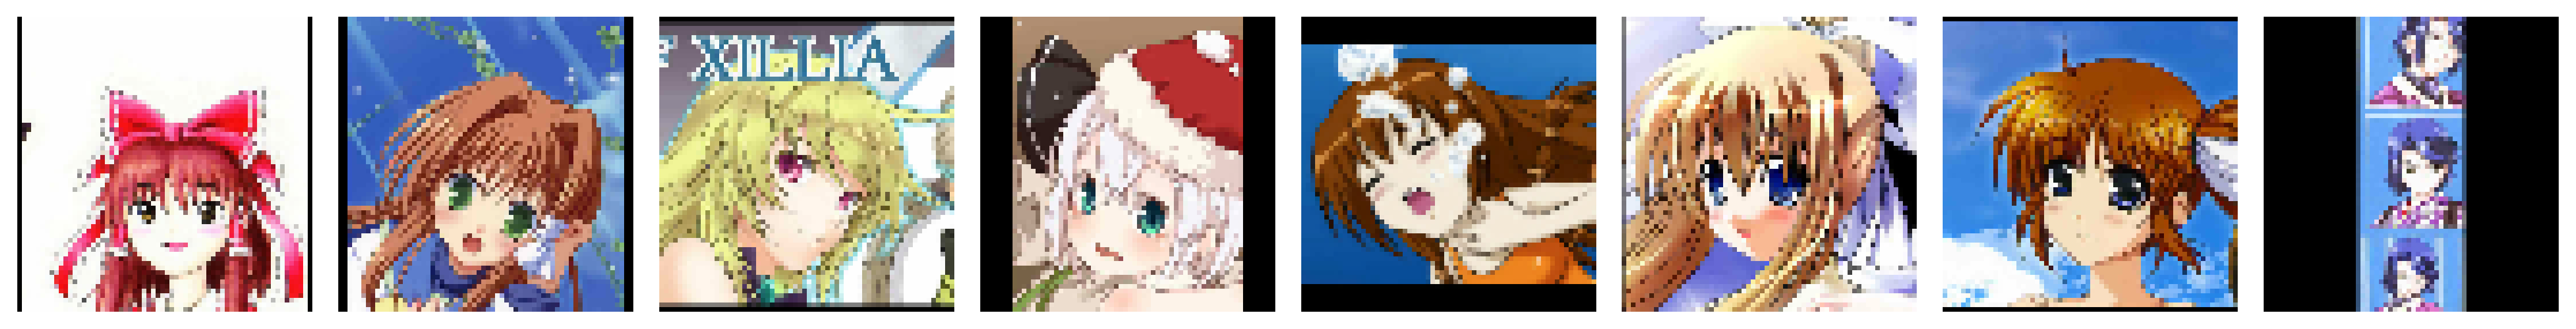

In [10]:
H = 64
W = 64
C = 3

P = 8
assert H == W
assert H % P == 0


h = 8

D_model = P**2 * C
D_head = 256
D_fcn = 1024
num_layers = 6
N = (H * W) // (P * P)
BATCH_SIZE = 128

# D_model better be larger than P*P*C


MASK_MAX_SIZE = 30
MASK_MIN_SIZE = 30
assert MASK_MAX_SIZE < H

keras.mixed_precision.set_global_policy("mixed_bfloat16")
FLOAT = tf.bfloat16


def random_visibility_mask():
    "-> {0,1}^{H x W x C}"
    w, h = [np.random.randint(MASK_MIN_SIZE, MASK_MAX_SIZE + 1) for _ in range(2)]
    x = np.random.randint(0, W - w + 1)
    y = np.random.randint(0, H - h + 1)

    mask = tf.ones((H, W), dtype=tf.bool)
    mask = tf.tensor_scatter_nd_update(
        mask,
        tf.stack(
            tf.meshgrid(tf.range(y, y + h), tf.range(x, x + w), indexing="ij"), axis=-1
        ),
        tf.zeros((h, w), dtype=tf.bool),
    )
    return tf.expand_dims(mask, -1)


ds_shape_advertised = (512, 512, 3)


def load_and_validate(file_path):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_image(img, channels=C, expand_animations=False)
    img = tf.divide(tf.cast(img, FLOAT), 255.0)
    is_valid = tf.reduce_all(tf.equal(tf.shape(img), tf.constant(ds_shape_advertised)))

    return img, is_valid


dataset_path = "/mnt/Data/ML/datasets/portraits"
num_samples = 5000


all_files = [
    os.path.join(dataset_path, f)
    for f in os.listdir(dataset_path)
    if f.endswith((".jpg", ".png"))
]
random.shuffle(all_files)
selected_files = all_files[:num_samples]
dataset = tf.data.Dataset.from_tensor_slices(selected_files)
dataset = dataset.map(load_and_validate)
dataset = dataset.filter(lambda img, is_valid: is_valid)
dataset = dataset.map(lambda img, is_valid: img)
dataset = dataset.map(lambda img: tf.cast(tf.image.resize(img, (H, W)), FLOAT))

# tf.print(next(iter(dataset.take(1)))[0].dtype)
# with tf.device("/cpu:0"):
valid_count = dataset.reduce(
    tf.constant(0, dtype=tf.int32), lambda x, _: x + 1
).numpy()  # type: ignore

print(f"Valid images count: {valid_count}")
assert valid_count, "Everything's gone"

masks = [random_visibility_mask() for _ in range(valid_count)]
mask_dataset = tf.data.Dataset.from_tensor_slices(masks)

ds_masks = tf.data.Dataset.zip((dataset, mask_dataset))

train_count = int(valid_count * 0.8)
test_count = int(valid_count * 0.1)
val_count = valid_count - train_count - test_count

train_ds = ds_masks.take(train_count).batch(BATCH_SIZE)
test_ds = ds_masks.skip(train_count).take(test_count).batch(BATCH_SIZE)
val_ds = ds_masks.skip(train_count + test_count).take(val_count).batch(BATCH_SIZE)

train_batches = -(train_count // -BATCH_SIZE)
test_batches = -(test_count // -BATCH_SIZE)
val_batches = -(val_count // -BATCH_SIZE)

print("Trn,Tst,Val:", train_count, test_count, val_count)
viz_grid(next(iter(train_ds.take(1).map(lambda img, mask: img))), 8)

<dtype: 'bfloat16'>


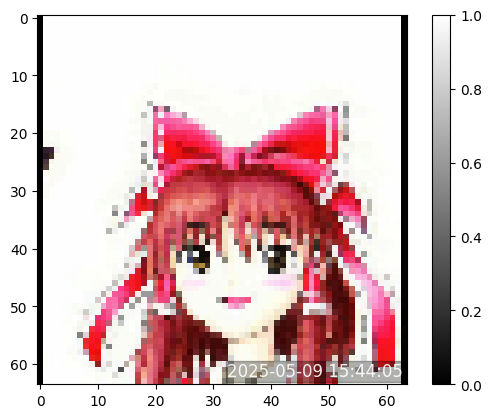

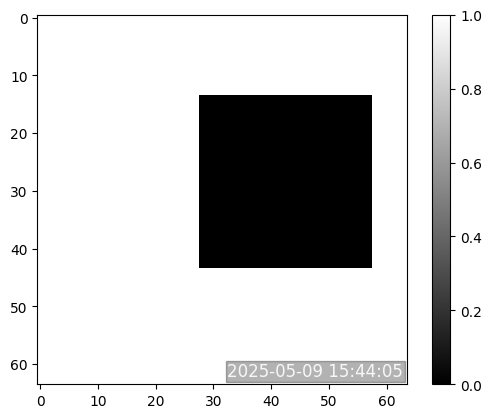

In [11]:
def extract_patches(image: tf.Tensor) -> tf.Tensor:
    "R^{BS x H x W x C} -> R^{BS x N x P^2 x C}"

    patches: tf.Tensor = tf.image.extract_patches(
        images=image,
        sizes=[1, P, P, 1],
        strides=[1, P, P, 1],
        rates=[1, 1, 1, 1],
        padding="VALID",
    )
    BS, H_prime, W_prime, _ = tf.unstack(tf.shape(patches))

    # Reshape patches to [BS, H' * W', P*P, C]
    patches = tf.reshape(patches, [BS, H_prime * W_prime, P * P, -1])

    return patches


def patches_to_imgs(patches: tf.Tensor) -> tf.Tensor:
    "R^{BS x N x (P^2.C)} -> R^{BS x H x W x C}"
    BS = tf.shape(patches)[0]
    grid_size = H // P  # same as W // P
    patches = tf.reshape(patches, [BS, grid_size, grid_size, P, P, C])
    patches = tf.transpose(patches, perm=[0, 1, 3, 2, 4, 5])
    image = tf.reshape(patches, [BS, grid_size * P, grid_size * P, C])

    return image


sample = tf.expand_dims(next(iter(dataset.take(1))), 0)
tf.assert_equal(patches_to_imgs(extract_patches(sample)), sample)


def create_attention_mask(obvmask: tf.Tensor):
    "R^{BS x H x W} -> R^{BS x N x N}"
    # TF does not support native min pooling.
    # The mask shown is OBSERVATION MASK meaning 0 means missing.

    BS = tf.shape(obvmask)[0]
    mask_pooled = tf.nn.max_pool2d(
        tf.cast(tf.logical_not(obvmask), dtype=tf.int8),
        ksize=[P, P],
        strides=[P, P],
        padding="VALID",
    )
    mask_pooled = tf.logical_not(tf.cast(mask_pooled, tf.bool))
    # viz_mask(mask_pooled)
    mask_pooled = tf.reshape(mask_pooled, [BS, N])
    mask_expanded = tf.expand_dims(mask_pooled, axis=1)  # (BS, 1, N)
    mask_expanded = tf.tile(mask_expanded, [1, N, 1])  # (BS, N, N)
    A = tf.where(
        mask_expanded,
        tf.constant(0.0, dtype=FLOAT),  # zero penanly
        tf.constant(-float("inf"), dtype=FLOAT),  # inf penalty
    )
    return A


sample = next(iter(train_ds.unbatch().take(1)))
print(sample[0].dtype)
viz_img(sample[0])
viz_mask(sample[1])

In [12]:
commonDense = {"dtype": FLOAT, "kernel_initializer": initializer}


class PatchEmbedding(keras.layers.Layer):
    def __init__(self):
        super().__init__(dtype=FLOAT)
        self.proj = keras.layers.Dense(D_model, **commonDense)  # (P² * C) -> D_model

    def build(self, input_shape):
        self.positional_embedding = self.add_weight(
            shape=(N, D_model), initializer=initializer, name="pos_embed"
        )

    def call(self, patches_flat: tf.Tensor):
        # R^{BS x N x (P^2 . C)} -> R^{BS x N x D_model}
        X = self.proj(patches_flat)
        X += self.positional_embedding
        return X


class MultiHeadAttention(keras.layers.Layer):
    def __init__(self):
        super().__init__(dtype=FLOAT)
        # Project to h * D_head dimensions
        self.W_Q = keras.layers.Dense(h * D_head, **commonDense)
        self.W_K = keras.layers.Dense(h * D_head, **commonDense)
        self.W_V = keras.layers.Dense(h * D_head, **commonDense)
        # Project back to D_model
        self.W_O = keras.layers.Dense(D_model, **commonDense)

    def call(self, X, A):
        """
        X: R^{BS x N x D_model}, A: R^{BS x N x N} -> R^{BS x N x D_model}
        """

        # In the standard implementation, each head has its own separate projection matrices. However, a common optimization is to project the input into h * D_head dimensions (which is D_model) with a single large projection, then split into h heads. So, if D_model = h * D_head, then using a Dense(D_model) for Q, K, V and then splitting into h heads each of D_head is equivalent to having h separate projections. This is a standard approach because it's more efficient to compute all heads in parallel with a single matrix multiplication rather than h separate ones.
        # So the optimal way is to use combined projections.
        Q = self.W_Q(X)  # (BS, N, h * D_head)
        K = self.W_K(X)  # (BS, N, h * D_head)
        V = self.W_V(X)  # (BS, N, h * D_head)

        Q = tf.reshape(Q, (-1, N, h, D_head))  # (BS, N, h, D_head)
        K = tf.reshape(K, (-1, N, h, D_head))
        V = tf.reshape(V, (-1, N, h, D_head))

        # Transpose for attention computation
        Q = tf.transpose(Q, [0, 2, 1, 3])  # (BS, h, N, D_head)
        K = tf.transpose(K, [0, 2, 1, 3])
        V = tf.transpose(V, [0, 2, 1, 3])
        # scaled dot-product attention
        attn_scores = tf.matmul(Q, K, transpose_b=True)  # (BS, h, N, N)
        attn_scores /= tf.math.sqrt(
            tf.cast(D_head, attn_scores.dtype)
        )  # scale by sqrt(D_head)

        A = tf.expand_dims(A, 1)  # (BS, 1, N, N)
        attn_scores += A  # Broadcast to all heads

        attn_weights = tf.nn.softmax(attn_scores, axis=-1)  # (BS, h, N, N)

        output = tf.matmul(attn_weights, V)  # (BS, h, N, D_head)
        output = tf.transpose(output, [0, 2, 1, 3])  # (BS, N, h, D_head)
        output = tf.reshape(output, (-1, N, h * D_head))  # (BS, N, h * D_head)
        output = self.W_O(output)  # (BS, N, D_model)
        return output


class KMultiHeadAttention(keras.layers.Layer):
    def __init__(self):
        super().__init__(dtype=FLOAT)
        self.mha = keras.layers.MultiHeadAttention(
            num_heads=h,
            key_dim=D_head,  # must satisfy h * D_head = D_model
            dropout=0.1,
            output_shape=D_model,
            use_bias=True,
        )

    def call(self, X, A):
        "R^{BS x N x D_model}, R^{BS x N x N} -> R^{BS x N x D_model}"
        return self.mha(X, X, attention_mask=A)


class TransformerBlock(keras.layers.Layer):
    def __init__(self):
        super().__init__(dtype=FLOAT)
        self.attn = KMultiHeadAttention()
        self.norm1 = keras.layers.LayerNormalization(dtype=FLOAT)
        self.norm2 = keras.layers.LayerNormalization(dtype=FLOAT)
        self.ffn = keras.Sequential(
            [
                keras.layers.Dense(
                    D_fcn, activation="relu", **commonDense
                ),  # Switched to ReLU
                keras.layers.Dense(D_model, **commonDense),
            ]
        )

    def call(self, X, A):
        "R^{BS x N x D_model} -> R^{BS x N x D_model}"

        # NEW : pre norm blocks
        X_norm = self.norm1(X)
        X_attn = self.attn(X_norm, A)
        X = X + X_attn
        X_norm2 = self.norm2(X)
        X_ffn = self.ffn(X_norm2)
        X = X + X_ffn
        return X


class Refiner(keras.layers.Layer):
    def __init__(self):
        super().__init__(dtype=FLOAT)
        self.conv1 = keras.layers.Conv2D(64, 3, padding="same", activation="relu")
        self.conv2 = keras.layers.Conv2D(
            128, 3, dilation_rate=2, padding="same", activation="relu"
        )
        self.conv3 = keras.layers.Conv2D(3, 3, padding="same")

    def call(self, X):
        "R^{BS x H x W x C} -> R^{BS x H x W x C}"
        residual = X
        X = self.conv1(X)
        X = self.conv2(X)  # Dilated conv for wider context
        X = self.conv3(X)
        return X + residual


class TransformerDecoder(keras.layers.Layer):
    "R^{BS x N x D_model} -> R^{BS x N x P*P*C}"

    def __init__(self):
        super().__init__(dtype=FLOAT)
        self.proj1 = keras.layers.Dense(D_model, activation="gelu", **commonDense)
        self.proj2 = keras.layers.Dense(P * P * C, activation="sigmoid", **commonDense)

    def call(self, X):
        BS = tf.shape(X)[0]
        X = self.proj1(X)
        X = self.proj2(X)
        return tf.reshape(X, (BS, N, P, P, C))


class ImageInpaintingTransformer(keras.Model):
    def __init__(self):
        super().__init__(dtype=FLOAT)
        self.embed = PatchEmbedding()
        self.transformer_blocks = [TransformerBlock() for _ in range(num_layers)]
        self.decoder = TransformerDecoder()
        self.refiner = Refiner()

    def build(self, input_shape):
        BS = input_shape[0]
        # dummy_images = tf.zeros((BS, H, W, C), dtype=FLOAT)  # THIS WASTED 40 MINUTES
        self.call(*next(iter(val_ds.take(1))))
        self.built = True

    def call(self, image, obvmask):
        image = tf.multiply(image, tf.cast(obvmask, FLOAT))
        # viz_img(image[0])
        patches = extract_patches(image)
        AttnMask = create_attention_mask(obvmask)
        # viz_img(AttnMask[0])

        BS = tf.shape(patches)[0]
        patches_flat = tf.reshape(patches, [BS, N, P**2 * C])
        # tf.print(tf.shape(patches_flat))
        X = self.embed(patches_flat)
        for block in self.transformer_blocks:
            X = block(X, AttnMask)

        # return self.decoder(X)
        # reconstructed_patches = self.decoder(X)
        raw_reconstr = patches_to_imgs(X)
        return raw_reconstr
        # return self.refiner(raw_reconstr)


model = ImageInpaintingTransformer()
model.build((BATCH_SIZE, H, W, C))
# model.compute_output_shape((BATCH_SIZE, H, W, C))
model.summary()

session_epochs = 0

Model: "image_inpainting_transformer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ patch_embedding                 │ ?                      │        49,344 │
│ (PatchEmbedding)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block               │ ?                      │     1,974,400 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_1             │ ?                      │     1,974,400 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_2             │ ?                      │     1,974,400 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_3             │ ?                      │     1,974,400 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_4             │ ?                      │     1,974,400 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_5             │ ?                      │     1,974,400 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_decoder             │ ?                      │   0 (unbuilt) │
│ (TransformerDecoder)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ refiner (Refiner)               │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,895,744 (40.76 MB)

 Trainable params: 11,895,744 (40.76 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
EPOCHS_TO_TRAIN = 50
# name = "decoder_unet_1.keras"
# model.load_weights(name)
# model.save(name)

In [14]:
def costfunc(y_true: tf.Tensor, y_pred: tf.Tensor, obsvmask: tf.Tensor) -> tf.RaggedTensor:
    errors = tf.square(tf.subtract(y_true, y_pred))
    inpaintmask = tf.cast(tf.logical_not(obsvmask), FLOAT)
    masked_errors = tf.multiply(errors, inpaintmask)
    sum_masked_errors = tf.reduce_sum(masked_errors)
    area = tf.reduce_sum(inpaintmask)
    eps = tf.cast(keras.backend.epsilon(), area.dtype)
    masked_loss = sum_masked_errors / area + eps

    # global_loss = tf.reduce_mean(errors)
    # return masked_loss + global_loss
    return masked_loss


# optimizer = keras.optimizers.AdamW(
#     learning_rate=3e-4,
#     weight_decay=0.05,
#     clipvalue=1.0
# )
optimizer = keras.optimizers.Adam(learning_rate=1e-4)


def train_step(image: tf.Tensor, mask: tf.Tensor) -> tf.RaggedTensor:
    with tf.GradientTape() as tape:
        reconstructed_img = model(image, mask)
        loss = costfunc(image, reconstructed_img, mask)
    gradients = tape.gradient(loss, model.trainable_variables)
    if gradients is None:
        raise RuntimeError()
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss


def val_step(image: tf.Tensor, mask: tf.Tensor) -> tf.RaggedTensor:
    reconstructed_img = model(image, mask, training=False)
    loss = costfunc(image, reconstructed_img, mask)
    return loss

In [ ]:
assert isinstance(session_epochs, int)
print(
    f"Starting training for {EPOCHS_TO_TRAIN - session_epochs} epochs for a total of {EPOCHS_TO_TRAIN} epochs"
)

best_val_loss = float("inf")
best_epoch = -1
for _ in range(EPOCHS_TO_TRAIN - session_epochs):
    epoch_loss = 0.0
    steps = 0
    pbar = tqdm(
        train_ds,
        desc=f"Epoch {session_epochs+1}",
        unit="batch",
        total=train_batches,
    )
    for image_batch, mask_batch in pbar:
        tfloss = train_step(image_batch, mask_batch).numpy()
        epoch_loss += tfloss
        steps += 1
        # Dynamically update the tqdm bar without spamming stdout
        pbar.set_postfix(loss=f"{float(tfloss):.4f}")
    train_loss = epoch_loss / steps

    val_loss_total = 0.0
    val_steps = 0
    pbar_val = tqdm(
        val_ds,
        desc=f"Epoch {session_epochs+1} Validation",
        unit="batch",
        total=val_batches,
    )
    for val_image_batch, val_mask_batch in pbar_val:
        tfvloss = val_step(val_image_batch, val_mask_batch).numpy()
        val_loss_total += tfvloss
        val_steps += 1
        pbar_val.set_postfix(loss=f"{float(tfvloss):.4f}")

    avg_val_loss = val_loss_total / val_steps
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_epoch = session_epochs + 1
        model.save("best_run.keras")
    print(
        f"Epoch {session_epochs+1} trained for {steps} steps \n Summary: Train Loss = {train_loss:.4f} | Validation Loss = {avg_val_loss:.4f}"
    )
    session_epochs += 1

Starting training for 50 epochs for a total of 50 epochs


Epoch 1:   0%|          | 0/32 [00:00<?, ?batch/s]

bfloat16


ValueError: Unknown format code 'f' for object of type 'str'

In [ ]:
def apply_obsv_mask(image: tf.Tensor, obvmask: tf.Tensor) -> tf.Tensor:
    return tf.multiply(image, tf.cast(obvmask, FLOAT))


def reconstruct(original: tf.Tensor, reconstruct: tf.Tensor, obvmask: tf.Tensor)  -> tf.Tensor:
    return tf.add(
        tf.multiply(tf.cast(obvmask, FLOAT), original),
        tf.multiply(tf.cast(tf.logical_not(obvmask), FLOAT), reconstruct),
    )

In [ ]:
img, obvmask = next(iter(train_ds.take(1)))
viz_grid(img)
viz_grid(apply_obsv_mask(img, obvmask))
model_out = model(img, obvmask)
reconstructed = reconstruct(img, model(img, obvmask), obvmask)
# viz_grid(reconstructed)
viz_grid(model_out)

# viz_img(model_out[0])
# viz_img(img[0])

In [ ]:
# Qualitative Eval
# visualize_unbatched_dataset(test_ds, 5)


# img = tf.image.decode_image(
#     tf.io.read_file("/home/navid/Dev/PaperTex/impl/naruto")
#     , dtype=tf.float32)
# img = tf.image.resize_with_crop_or_pad(img, H, W)
# img = tf.expand_dims(img, 0)
# tf.print(tf.shape(img))
# obvmask = tf.expand_dims(random_visibility_mask(),0)
# tf.print(tf.shape(obvmask))